In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import shap
from scipy.stats import uniform, randint

data = pd.read_csv('data/EPC_Catalonia.csv')

In [97]:
# Load data
df = data.copy()
# Define target variable (Energy Consumption)
target = "Consum d'energia final"

# Extract date features
df["DATA_ENTRADA"] = pd.to_datetime(df["DATA_ENTRADA"], errors="coerce")
df["YEAR"] = df["DATA_ENTRADA"].dt.year
df["MONTH"] = df["DATA_ENTRADA"].dt.month

# Drop original date column
df.drop(columns=["DATA_ENTRADA"], inplace=True)

# Numerical features
numeric_features = [
    "METRES_CADASTRE", "ANY_CONSTRUCCIO", "Energia primària no renovable", "Emissions de CO2",
    "Energia calefacció", "Energia refrigeració", "Energia ACS", "Energia enllumenament",
    "Energia calefacció demanda", "Energia refrigeració demanda", "VALOR AILLAMENTS",
    "VALOR FINESTRES", "YEAR", "MONTH", "Cost anual aproximat d'energia per habitatge"
]

# Categorical features (to encode)
categorical_features = [
    "POBLACIO", "COMARCA", "NOM_PROVINCIA", "CODI_POBLACIO", "CODI_COMARCA", "CODI_PROVINCIA",
    "ZONA CLIMATICA", "US_EDIFICI", "VEHICLE ELECTRIC", "SOLAR TERMICA", "SOLAR FOTOVOLTAICA",
    "SISTEMA BIOMASSA", "XARXA DISTRICTE", "ENERGIA GEOTERMICA", "REHABILITACIO_ENERGETICA",
    "Qualificació de consum d'energia primaria no renovable", "Qualificacio d'emissions de CO2"
]

# Convert binary categorical features to numeric (Yes/No -> 1/0)
binary_features = ["VEHICLE ELECTRIC", "SOLAR TERMICA", "SOLAR FOTOVOLTAICA", 
                   "SISTEMA BIOMASSA", "XARXA DISTRICTE", "ENERGIA GEOTERMICA", 
                   "REHABILITACIO_ENERGETICA"]

for col in binary_features:
    df[col] = df[col].str.lower().map({'si': 1, 'no': 0})        


/var/folders/xz/5bn1vdj146n6586g9r465k_40000gn/T/ipykernel_28264/334791769.py:1: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/EPC_Catalonia.csv')
/var/folders/xz/5bn1vdj146n6586g9r465k_40000gn/T/ipykernel_28264/334791769.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["DATA_ENTRADA"] = pd.to_datetime(df["DATA_ENTRADA"], errors="coerce")


In [98]:
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert to string to handle NaNs
    label_encoders[col] = le  # Store encoder for future use

# Drop NaN values
df = df[numeric_features + categorical_features + [target]].dropna()


In [99]:
# Split data into train/test
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [100]:
# Standardize numerical features
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# ---- Linear Regression Model ----
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Metrics for Linear Regression
print("\nLinear Regression Metrics:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_lr):.2f}")


Linear Regression Metrics:
MAE: 58.55
RMSE: 109.68
R² Score: 0.40


In [101]:
# ---- Polynomial Regression (Degree 7) ----
poly = PolynomialFeatures(degree=3)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)

# Predictions
y_pred_poly = poly_model.predict(X_poly_test)

# Metrics for Polynomial Regression
print("\nPolynomial Regression (Degree 3) Metrics:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_poly):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_poly)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_poly):.4f}")


Polynomial Regression (Degree 3) Metrics:
MAE: 211.99
RMSE: 397.46
R² Score: -6.9183


In [102]:
# ---- XGBRegressor with RandomizedSearchCV ----
xgb = XGBRegressor(random_state=42)

param_grid = {
    "n_estimators": [100, 500, 700, 1000, 1500],  # Between 500 and 1500 trees
    "max_depth": [10, 15, 17, 30, 50],  # Depth of the tree from 5 to 30
    "learning_rate": [0.001, 0.005, 0.01, 0.02],  # Small learning rates for stability
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],  # Minimum child weight
}

grid_search = GridSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=42),
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
)




In [103]:
# Fit the model with RandomizedSearchCV
scaler = StandardScaler()
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("\nBest XGBoost Parameters:", best_params)

# Train final XGB model with best parameters
xgb_best = XGBRegressor(**best_params, random_state=42)
xgb_best.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_best.predict(X_test)

# Metrics for XGBRegressor
print("\nOptimized XGBRegressor Metrics:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_xgb):.4f}")



Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.8}

Optimized XGBRegressor Metrics:
MAE: 32.88
RMSE: 86.23
R² Score: 0.6273


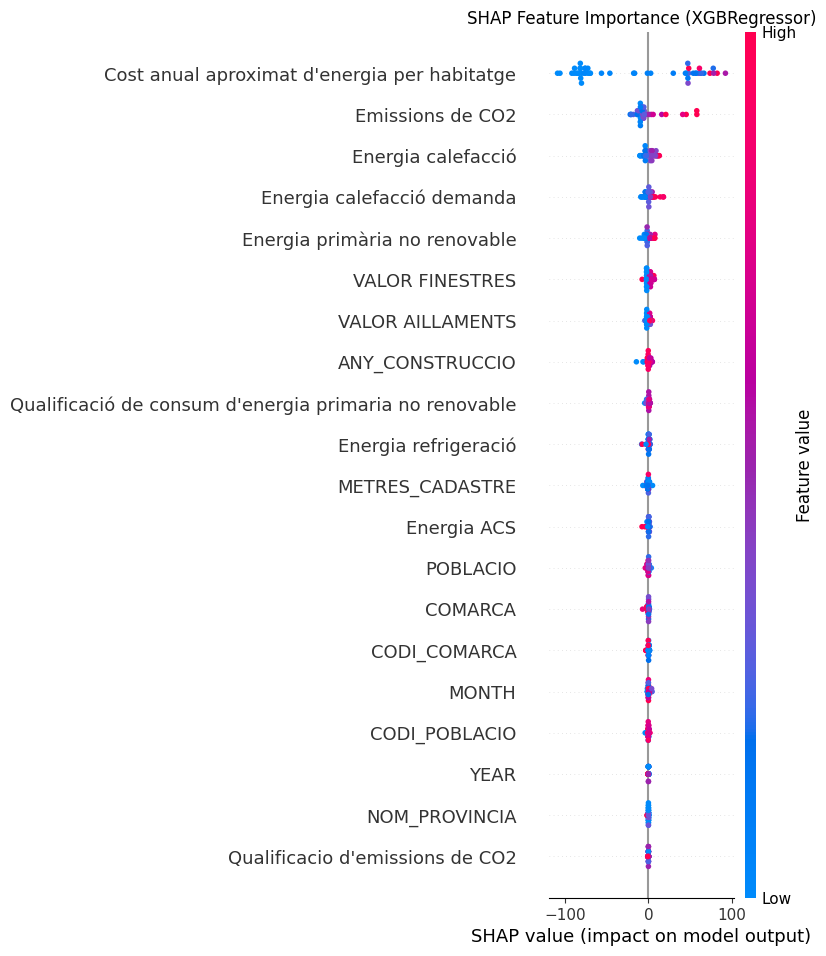

In [104]:
# ---- Feature Importance with SHAP for XGB ----
explainer = shap.Explainer(xgb_best)
shap_values = explainer(X_test)

# Plot SHAP Summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Importance (XGBRegressor)")
plt.show()



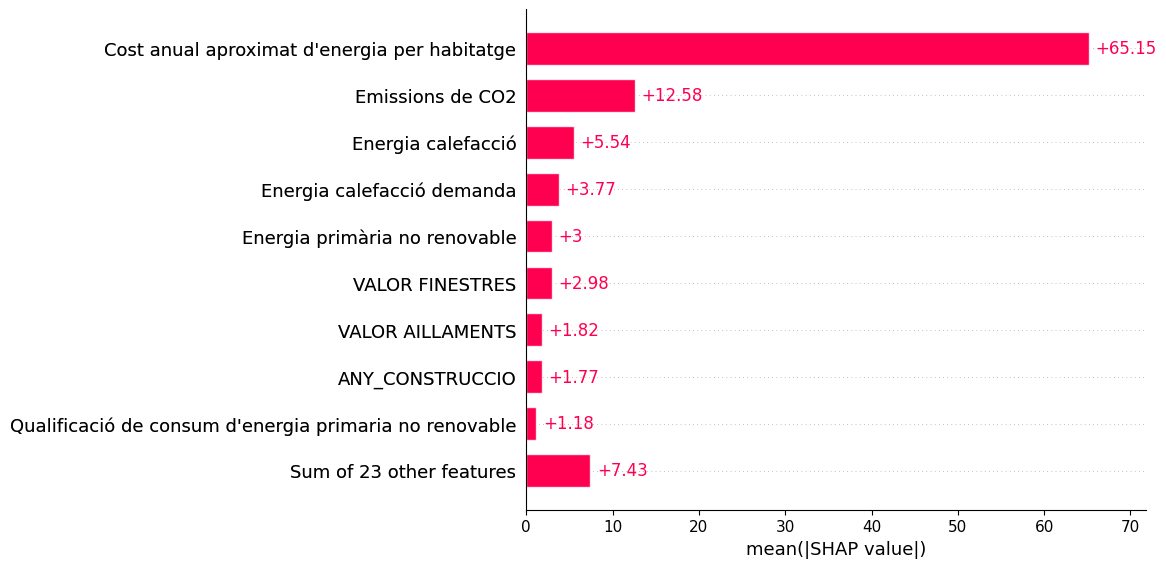

In [105]:
shap.plots.bar(shap_values, max_display=10)

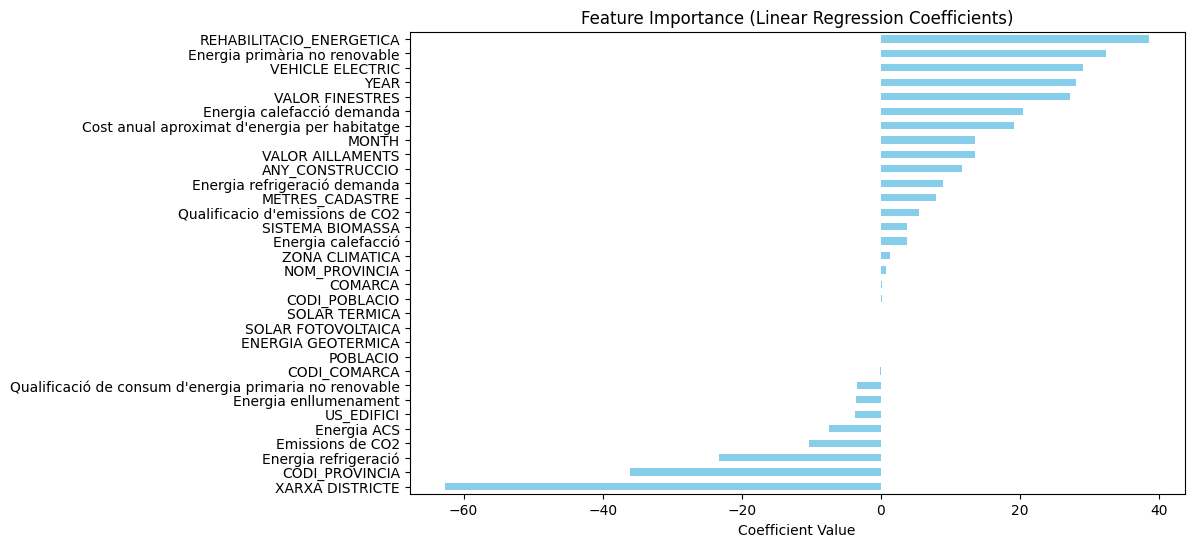

In [106]:
# ---- Feature Importance for Polynomial Regression ----
plt.figure(figsize=(10, 6))
coefficients = pd.Series(lr_model.coef_, index=lr_model.feature_names_in_)
coefficients.sort_values().plot(kind="barh", color="skyblue")
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.show()